# Projet Métaheuristique
http://dimacs.rutgers.edu/programs/challenge/vrp/cvrp/<br>
http://vrp.galgos.inf.puc-rio.br/index.php/en/plotted-instances?data=X-n101-k25<br>
http://dimacs.rutgers.edu/files/6916/3848/0327/CVRP_Competition_Rules.pdf<br>
https://www.cirrelt.ca/documentstravail/cirrelt-2011-12.pdf<br>
https://www.jstor.org/stable/pdf/4102067.pdf?refreqid=excelsior%3Ac082c879db7df12627f560be34e84feb&ab_segments=&origin=

In [58]:
Instance = "X-n120-k6"
Instance = "X-n101-k25"
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.sol
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/{Instance}.vrp
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
!wget -c http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.sol 

--2022-03-23 19:41:45--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n101-k25.sol
Résolution de vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)… 139.82.16.196
Connexion à vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)|139.82.16.196|:80… connecté.
requête HTTP transmise, en attente de la réponse… 416 Requested Range Not Satisfiable

    Le fichier a déjà été complètement récupéré ; rien à faire.

--2022-03-23 19:41:46--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n101-k25.vrp
Résolution de vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)… 139.82.16.196
Connexion à vrp.galgos.inf.puc-rio.br (vrp.galgos.inf.puc-rio.br)|139.82.16.196|:80… connecté.
requête HTTP transmise, en attente de la réponse… 416 Requested Range Not Satisfiable

    Le fichier a déjà été complètement récupéré ; rien à faire.

--2022-03-23 19:41:47--  http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances//X/X-n120-k6.vrp
Résolution de vrp.galgos.inf.puc-rio.br (

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
problem = open(Instance+".vrp", "r")
print(problem.read(398))

NAME : 	X-n101-k25	
COMMENT : 	"Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013)"	
TYPE : 	CVRP	
DIMENSION : 	101	
EDGE_WEIGHT_TYPE : 	EUC_2D	
CAPACITY : 	206	
NODE_COORD_SECTION		
1	365	689
2	146	180
3	792	5
4	658	510
5	461	270
6	299	531
7	812	228
8	643	90
9	615	630
10	258	42
11	616	299
12	475	957
13	425	473
14	406	64
15	656	369
16	202	467
17	318	21
18	579	587
19	458	354



In [60]:
# The input files follow the "Augerat" format.
import math
import sys
def read_input_cvrp(filename):
    file_it = iter(read_elem(filename))
    nb_trucks = get_nb_trucks(filename)
    nb_nodes = 0
    while (1):
        token = next(file_it)
        if token == "DIMENSION":
            next(file_it)  # Removes the ":"
            nb_nodes = int(next(file_it))
            nb_customers = nb_nodes - 1
        elif token == "CAPACITY":
            next(file_it)  # Removes the ":"
            truck_capacity = int(next(file_it))
        elif token == "EDGE_WEIGHT_TYPE":
            next(file_it)  # Removes the ":"
            token = next(file_it)
            if token != "EUC_2D":
                print("Edge Weight Type " + token + " is not supported (only EUD_2D)")
                sys.exit(1)
        elif token == "NODE_COORD_SECTION":
            break

    customers_x = [None] * nb_customers
    customers_y = [None] * nb_customers
    depot_x = 0
    depot_y = 0
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            depot_x = int(next(file_it))
            depot_y = int(next(file_it))
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            customers_x[node_id - 2] = int(next(file_it))
            customers_y[node_id - 2] = int(next(file_it))

    # Compute distance matrix
    distance_matrix = compute_distance_matrix(customers_x, customers_y)
    distance_warehouses = compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y)

    token = next(file_it)
    if token != "DEMAND_SECTION":
        print("Expected token DEMAND_SECTION")
        sys.exit(1)

    demands = [None] * nb_customers
    for n in range(nb_nodes):
        node_id = int(next(file_it))
        if node_id != n + 1:
            print("Unexpected index")
            sys.exit(1)
        if node_id == 1:
            if int(next(file_it)) != 0:
                print("Demand for depot should be 0")
                sys.exit(1)
        else:
            # -2 because orginal customer indices are in 2..nbNodes
            demands[node_id - 2] = int(next(file_it))

    token = next(file_it)
    if token != "DEPOT_SECTION":
        print("Expected token DEPOT_SECTION")
        sys.exit(1)

    warehouse_id = int(next(file_it))
    if warehouse_id != 1:
        print("Warehouse id is supposed to be 1")
        sys.exit(1)

    end_of_depot_section = int(next(file_it))
    if end_of_depot_section != -1:
        print("Expecting only one warehouse, more than one found")
        sys.exit(1)
    return (nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands)

def read_elem(filename):
    with open(filename) as f:
        return [str(elem) for elem in f.read().split()]

# Computes the distance matrix
def compute_distance_matrix(customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(customers_x[i], customers_x[j], customers_y[i], customers_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


# Computes the distances to warehouse
def compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_warehouses = [None] * nb_customers
    for i in range(nb_customers):
        dist = compute_dist(depot_x, customers_x[i], depot_y, customers_y[i])
        distance_warehouses[i] = dist
    return distance_warehouses


def compute_dist(xi, xj, yi, yj):
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5))


def get_nb_trucks(filename):
    begin = filename.rfind("-k")
    if begin != -1:
        begin += 2
        end = filename.find(".", begin)
        return int(filename[begin:end])
    print("Error: nb_trucks could not be read from the file name. Enter it from the command line")
    sys.exit(1)

In [61]:
nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands = read_input_cvrp(Instance+".vrp")
print("-- CUSTOMERS --")
print("There are",nb_customers,"customers")
print("- X position of the customers is size",np.array(customers_x).shape)
print("- Y position of the customers is size",np.array(customers_y).shape)
print("The demand of each client are is size",len(demands))
print("The distance matrix is size (euclidian distances between customer_x and customers_y)",np.array(distance_matrix).shape)
print("-- TRUCKS --")
print("There are at least",nb_trucks,"trucks")
print("The truck capacity is",truck_capacity)
print("-- WAREHOUSES --")
print("- X position of the warehouse",depot_x)
print("- Y position of the warehouse",depot_y)
print("The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size",len(distance_warehouses))

-- CUSTOMERS --
There are 100 customers
- X position of the customers is size (100,)
- Y position of the customers is size (100,)
The demand of each client are is size 100
The distance matrix is size (euclidian distances between customer_x and customers_y) (100, 100)
-- TRUCKS --
There are at least 25 trucks
The truck capacity is 206
-- WAREHOUSES --
- X position of the warehouse 365
- Y position of the warehouse 689
The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size 100


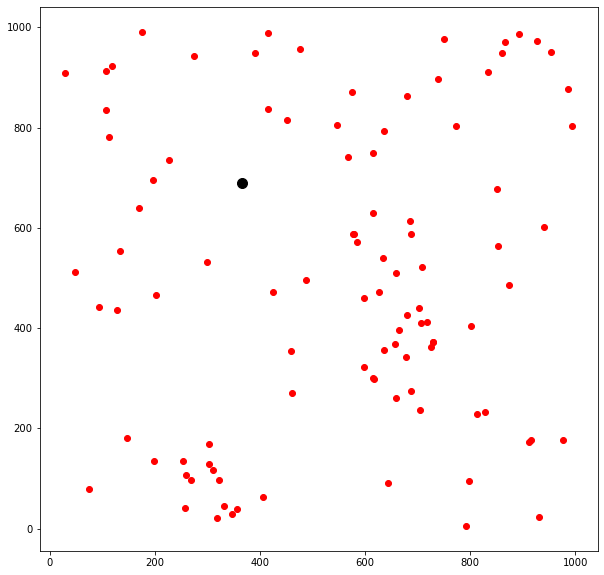

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(customers_x,customers_y,c="r")
plt.scatter(depot_x,depot_y,c="black",s=100)
plt.show()

## Route First

In [63]:
nb_customers, customers_x, customers_y, nb_trucks, truck_capacity, distance_matrix, depot_x, depot_y, distance_warehouses, demands = read_input_cvrp(Instance+".vrp")
print("-- CUSTOMERS --")
print("There are",nb_customers,"customers")
print("- X position of the customers is size",np.array(customers_x).shape)
print("- Y position of the customers is size",np.array(customers_y).shape)
print("The demand of each client are is size",len(demands))
print("The distance matrix is size (euclidian distances between customer_x and customers_y)",np.array(distance_matrix).shape)
print("-- TRUCKS --")
print("There are at least",nb_trucks,"trucks")
print("The truck capacity is",truck_capacity)
print("-- WAREHOUSES --")
print("- X position of the warehouse",depot_x)
print("- Y position of the warehouse",depot_y)
print("The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size",len(distance_warehouses))

-- CUSTOMERS --
There are 100 customers
- X position of the customers is size (100,)
- Y position of the customers is size (100,)
The demand of each client are is size 100
The distance matrix is size (euclidian distances between customer_x and customers_y) (100, 100)
-- TRUCKS --
There are at least 25 trucks
The truck capacity is 206
-- WAREHOUSES --
- X position of the warehouse 365
- Y position of the warehouse 689
The distance of each client to the warehouses are (euclidian distance between customer_x and warehouse) is size 100


# Heuristique
 - On crée une liste de clients à dispatcher.
 - On ajoute le premier élément de cette liste dans une route vide.
 - Ensuite on prend à chaque fois le client le plus proche du dernier client ajouté dans la route et tant que la somme des demandes de la route ne dépasse pas la capacité d'un camion, on ajoute le plus proche voisin.
 - Une fois que l'on ne peut plus ajouter aucun voisin à la route, on ajoute la route à la liste des routes.

In [64]:
def get_route_cost(route):
    total_cost = 0
    # Trajets jusqu'au dépôt
    x_values = [depot_x, customers_x[route[0]]]
    y_values = [depot_y, customers_y[route[0]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    x_values = [depot_x, customers_x[route[-1]]]
    y_values = [depot_y, customers_y[route[-1]]]
    total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    # Trajet entre clients
    for nb_customer in range(len(route)-1):
        x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
        y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
        total_cost += compute_dist(x_values[0],x_values[1],y_values[0],y_values[1])
    return total_cost

def get_route_capacity(route):
    total_capacity= 0
    # Trajet entre clients
    for customer in route:
        total_capacity += demands[customer]
    return total_capacity

def get_closest_from_warehouse(customers_list):
    closest_customer = customers_list[0]
    for customer in customers_list:
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = customer
        if distance_warehouses[customer]<distance_warehouses[closest_customer]:
            closest_customer = max(customer,closest_customer)
    return closest_customer

def get_closest_customer(current_customer,customers_list):
    closest_customer = customers_list[0] # Initialisation
    for new_customer in customers_list:
        smallest_distance = compute_dist(customers_x[current_customer],customers_x[closest_customer],customers_y[current_customer],customers_y[closest_customer]) 
        customer_distance = compute_dist(customers_x[current_customer],customers_x[new_customer],customers_y[current_customer],customers_y[new_customer]) 
        if customer_distance < smallest_distance:
            closest_customer = new_customer
        if customer_distance == smallest_distance:
            closest_customer = max(new_customer,closest_customer)
    return closest_customer

import random
def create_routes(custom_truck_capacity, initialization = 1):
    customers_list = list(np.arange(0,nb_customers,1)) # Initialisation
    random.shuffle(customers_list) # Aucun impact sur les performances
    routes = []
    while (len(customers_list)!=0):
        # print("Liste à dispatcher :",customers_list)
        route=[]
        if initialization==1:
            closest_customer = get_closest_from_warehouse(customers_list) # Initialisation
        if initialization==2:
            closest_customer = random.choice(customers_list) # Initialisation
        route_capacity = 0
        while (route_capacity + demands[closest_customer] <= custom_truck_capacity) and (len(customers_list)!=0):
            route.append(closest_customer)
            route_capacity = sum([demands[customer] for customer in route])
            customers_list.remove(closest_customer)
            if len(customers_list) > 0:
                closest_customer = get_closest_customer(route[-1],customers_list)
        routes.append(route)
        # print("Route:",route)
        # print("Demande:",route_capacity)
        # print("-------")
    return routes

def display_routes(routes):
    df = pd.DataFrame(columns=["customers_x","customers_y","demands","route"])
    route_number = 0
    iterator = 0
    for route in routes:
        for customer in route:
            new_line = np.array([customers_x[customer],customers_y[customer],demands[customer],route_number])
            df.loc[iterator]=new_line
            iterator += 1
        route_number += 1
        
    cmap = plt.get_cmap('jet', len(routes))
    cmap.set_under('gray')
    fig = plt.figure(figsize=(15,15))
    renderer = fig.canvas.get_renderer()
    for customer in range(nb_customers):
        plt.annotate(str(customer),[customers_x[customer],customers_y[customer]], )
        
    # Clients
    plt.scatter(df["customers_x"],df["customers_y"],c=df["route"],cmap=cmap,s=300)
    plt.colorbar()

    # Dépot
    plt.scatter(depot_x,depot_y,c="black",s=1000,marker='s')

    # Routes
    for route in routes:
        
        # Trajets jusqu'au dépôt
        x_values = [depot_x, customers_x[route[0]]]
        y_values = [depot_y, customers_y[route[0]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        x_values = [depot_x, customers_x[route[-1]]]
        y_values = [depot_y, customers_y[route[-1]]]
        plt.plot(x_values, y_values, marker="None", linestyle="--", c="lightgray")
        
        
        # Trajet entre clients
        for nb_customer in range(len(route)-1):
            x_values = [customers_x[route[nb_customer]], customers_x[route[nb_customer+1]]]
            y_values = [customers_y[route[nb_customer]], customers_y[route[nb_customer+1]]]
            plt.plot(x_values, y_values, marker="None", linestyle="-", c="black")
    plt.axis('scaled')

    plt.show()
    return df

# Initialisation

Cost | Capacity for route 0 : 619 | 154
Cost | Capacity for route 1 : 661 | 203
Cost | Capacity for route 2 : 769 | 204
Cost | Capacity for route 3 : 748 | 195
Cost | Capacity for route 4 : 709 | 153
Cost | Capacity for route 5 : 731 | 183
Cost | Capacity for route 6 : 620 | 152
Cost | Capacity for route 7 : 658 | 148
Cost | Capacity for route 8 : 620 | 119
Cost | Capacity for route 9 : 808 | 191
Cost | Capacity for route 10 : 801 | 174
Cost | Capacity for route 11 : 855 | 118
Cost | Capacity for route 12 : 1717 | 201
Cost | Capacity for route 13 : 1014 | 178
Cost | Capacity for route 14 : 984 | 188
Cost | Capacity for route 15 : 1085 | 176
Cost | Capacity for route 16 : 976 | 191
Cost | Capacity for route 17 : 1039 | 156
Cost | Capacity for route 18 : 1263 | 196
Cost | Capacity for route 19 : 1611 | 190
Cost | Capacity for route 20 : 1124 | 183
Cost | Capacity for route 21 : 1198 | 150
Cost | Capacity for route 22 : 1317 | 169
Cost | Capacity for route 23 : 1207 | 187
Cost | Capacity 

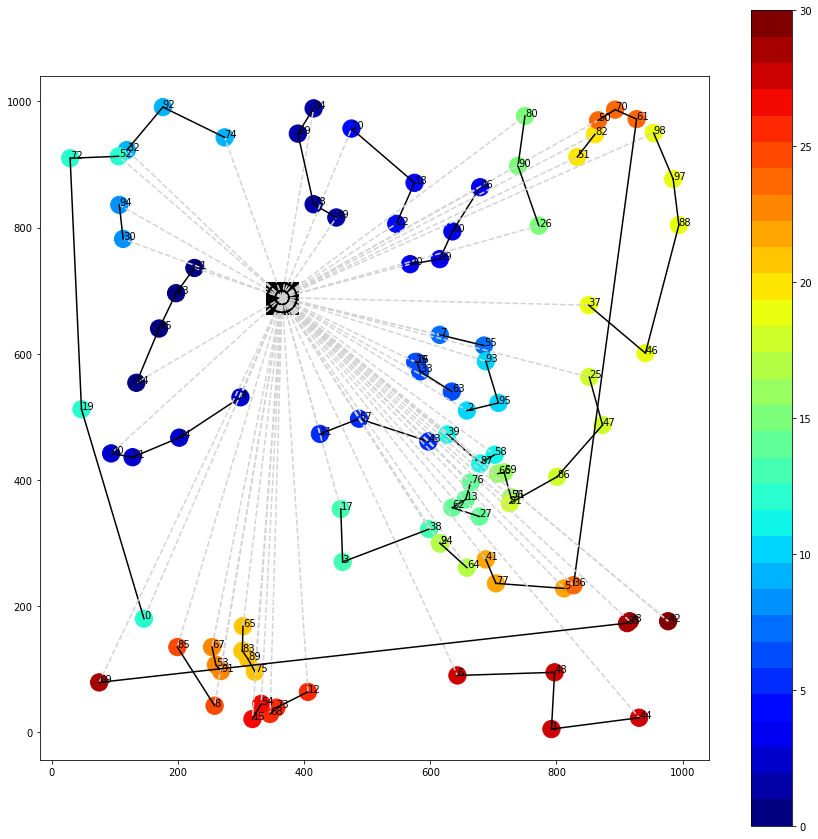

In [65]:
custom_truck_capacity = truck_capacity
routes = create_routes(custom_truck_capacity)

# Calcul du coût des routes
total_cost = 0 
for nb_route,route in enumerate(routes):
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(route),get_route_capacity(route)))
    total_cost+=get_route_cost(route)
print("Total cost = ",total_cost)
print(routes)
df = display_routes(routes)

# Changement d'initialisation
## Randomized-Initialisation

In [66]:
from tqdm import tqdm

trials_costs = []
trials_routes = []

for _ in tqdm(range(10000)):
    custom_truck_capacity = truck_capacity
    routes = create_routes(custom_truck_capacity,initialization=2) # Initialisation aléatoire

    # Calcul du coût des routes
    total_cost = 0 
    for nb_route,route in enumerate(routes):
        total_cost+=get_route_cost(route)
    # print("Total cost = ",total_cost)
    # print(routes)
    trials_routes.append(routes)
    trials_costs.append(total_cost)

100%|██████████| 10000/10000 [00:45<00:00, 218.61it/s]


The best cost we found is : 30614
The best routes for this cost are : [[96, 90, 80], [31, 23, 45, 34], [2, 63, 33, 16], [74, 92, 32], [73, 68, 54], [27, 13, 62, 76], [82, 50, 70], [12, 75, 89, 83, 65], [37, 25, 47, 86, 71, 56], [7, 79], [93, 55, 95, 58], [14, 21, 40, 19], [87, 66, 59], [42, 28, 35, 36], [46, 88, 97, 98, 61], [81, 41, 64, 77], [18, 22, 20, 99], [51, 26], [30, 94], [0, 85, 67], [17, 3, 38], [24, 9, 43], [8, 91, 53], [52, 72, 29, 84, 10], [78, 49], [5, 48, 1, 44, 6], [57, 11, 4], [15, 69], [39, 60]]
Cost | Capacity for route 0 : 989 | 137
Cost | Capacity for route 1 : 619 | 154
Cost | Capacity for route 2 : 693 | 155
Cost | Capacity for route 3 : 808 | 191
Cost | Capacity for route 4 : 1330 | 173
Cost | Capacity for route 5 : 995 | 188
Cost | Capacity for route 6 : 1221 | 194
Cost | Capacity for route 7 : 1319 | 196
Cost | Capacity for route 8 : 1350 | 169
Cost | Capacity for route 9 : 549 | 168
Cost | Capacity for route 10 : 958 | 206
Cost | Capacity for route 11 : 838 |

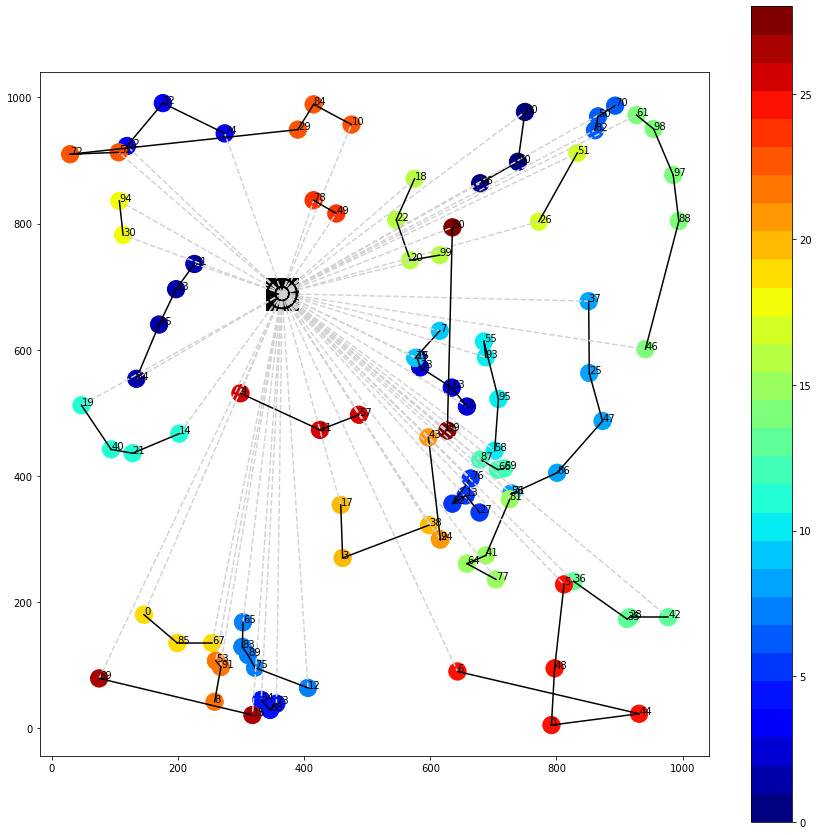

In [67]:
print("The best cost we found is :",min(trials_costs))
best_routes = trials_routes[np.argmin(trials_costs)]
print("The best routes for this cost are :",best_routes)
total_cost = 0
new_routes = []
for nb_route,route in enumerate(best_routes):
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(route),get_route_capacity(route)))
    total_cost+=get_route_cost(route)
print("Total cost = ",total_cost)
df = display_routes(best_routes)

# Optimisation

In [68]:
def reorder_route_v1(route):
    if len(route)>2:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
        
        route_end = get_closest_from_warehouse(customers_left)
        # print("Route ends by customer :",route_end)
        customers_left.remove(route_end)
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)
            
        best_route.append(route_end)
        return(best_route)
    else :
        return(route)

def reorder_route_v2(route):
    if len(route)>1:
        customers_left = route.copy()
        # print("Route de base :",customers_left)
        
        best_route = [get_closest_from_warehouse(customers_left)]
        # print("Route begins by customer :",best_route[0])
        customers_left.remove(best_route[0])
                
        while len(customers_left)>0:
            closest_customer = customers_left[0]
            closest_distance = compute_dist(customers_x[customers_left[0]],customers_x[best_route[-1]],customers_y[customers_left[0]],customers_y[best_route[-1]])
            # print("----")
            # print("Reste à dispatcher:",customers_left)
            for customer in customers_left:
                new_dist = compute_dist(customers_x[customer],customers_x[best_route[-1]],customers_y[customer],customers_y[best_route[-1]])
                if new_dist < closest_distance :
                    closest_customer = customer
                    closest_distance = new_dist
            # print("Client suivant :",closest_customer)
            customers_left.remove(closest_customer)
            # print("Client restant :",customers_left)
            best_route.append(closest_customer)
            # print("Middle Route :",middle_route)

        return(best_route)
    else :
        return(route)

## V1 : 

### On définit dès le départ le point de départ et d'arrivée de la route (les 2 points de la route les plus proches du dépot)

Cost | Capacity for route 0 : 1000 | 137
Cost | Capacity for route 1 : 674 | 154
Cost | Capacity for route 2 : 692 | 155
Cost | Capacity for route 3 : 808 | 191
Cost | Capacity for route 4 : 1330 | 173
Cost | Capacity for route 5 : 956 | 188
Cost | Capacity for route 6 : 1216 | 194
Cost | Capacity for route 7 : 1378 | 196
Cost | Capacity for route 8 : 1675 | 169
Cost | Capacity for route 9 : 549 | 168
Cost | Capacity for route 10 : 992 | 206
Cost | Capacity for route 11 : 928 | 205
Cost | Capacity for route 12 : 901 | 188
Cost | Capacity for route 13 : 1633 | 186
Cost | Capacity for route 14 : 1610 | 196
Cost | Capacity for route 15 : 1195 | 203
Cost | Capacity for route 16 : 672 | 186
Cost | Capacity for route 17 : 1066 | 174
Cost | Capacity for route 18 : 620 | 119
Cost | Capacity for route 19 : 1244 | 163
Cost | Capacity for route 20 : 1069 | 178
Cost | Capacity for route 21 : 951 | 190
Cost | Capacity for route 22 : 1312 | 197
Cost | Capacity for route 23 : 1441 | 202
Cost | Capaci

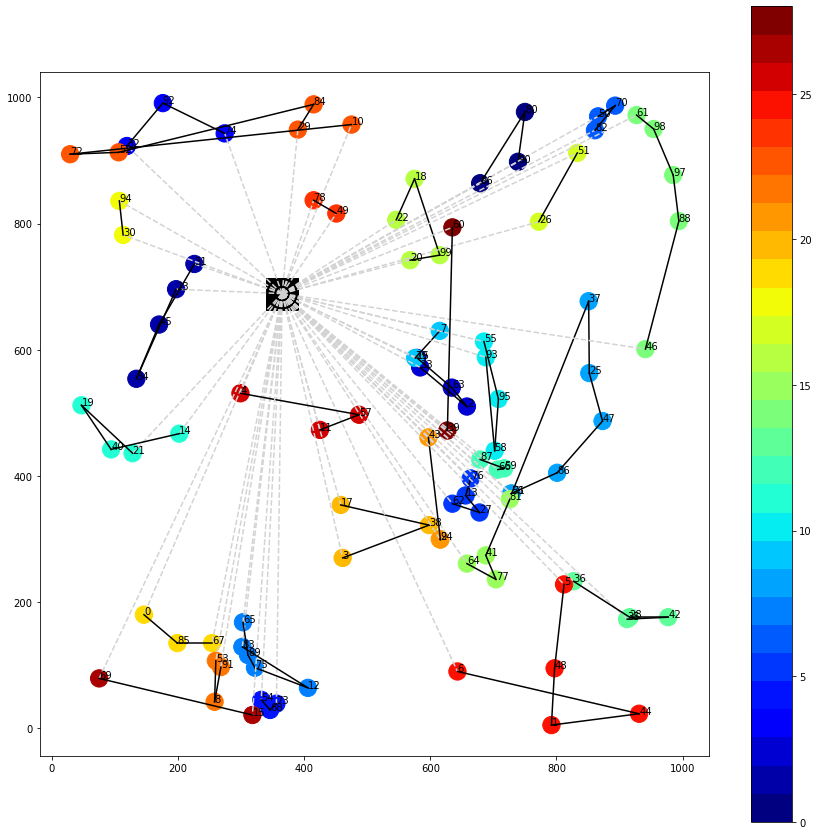

In [69]:
total_cost = 0
new_routes = []
for nb_route,route in enumerate(best_routes):
    best = reorder_route_v1(route)
    new_routes.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes)
df = display_routes(new_routes)

## V2 : 

### On définit dès le départ seulement le point de départ de la route : le plus proche du dépot

Cost | Capacity for route 0 : 989 | 137
Cost | Capacity for route 1 : 619 | 154
Cost | Capacity for route 2 : 693 | 155
Cost | Capacity for route 3 : 808 | 191
Cost | Capacity for route 4 : 1330 | 173
Cost | Capacity for route 5 : 984 | 188
Cost | Capacity for route 6 : 1221 | 194
Cost | Capacity for route 7 : 1319 | 196
Cost | Capacity for route 8 : 1350 | 169
Cost | Capacity for route 9 : 549 | 168
Cost | Capacity for route 10 : 924 | 206
Cost | Capacity for route 11 : 838 | 205
Cost | Capacity for route 12 : 900 | 188
Cost | Capacity for route 13 : 1618 | 186
Cost | Capacity for route 14 : 1610 | 196
Cost | Capacity for route 15 : 1234 | 203
Cost | Capacity for route 16 : 696 | 186
Cost | Capacity for route 17 : 1066 | 174
Cost | Capacity for route 18 : 620 | 119
Cost | Capacity for route 19 : 1244 | 163
Cost | Capacity for route 20 : 1014 | 178
Cost | Capacity for route 21 : 952 | 190
Cost | Capacity for route 22 : 1316 | 197
Cost | Capacity for route 23 : 1227 | 202
Cost | Capacit

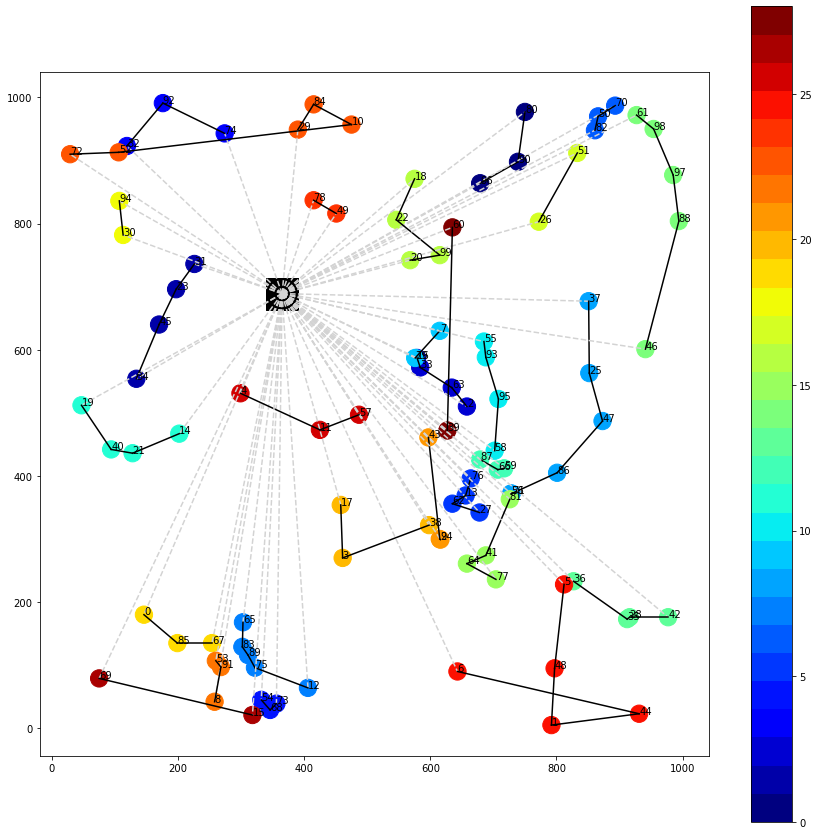

In [70]:
total_cost = 0
new_routes_v2 = []
for nb_route,route in enumerate(best_routes):
    best = reorder_route_v2(route)
    new_routes_v2.append(best)
    print("Cost | Capacity for route {} : {} | {}".format(nb_route,get_route_cost(best),get_route_capacity(best)))
    total_cost+=get_route_cost(best)
print("Total cost = ",total_cost)
print(new_routes_v2)
df = display_routes(new_routes_v2)